# London Fire Incidents Analysis

In [1]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data
import data_download

# data_dir = "LFB-data"
LFB_data = pd.read_csv("LFB Incident data - Datastore - with notional cost and UPRN from January 2009.csv")
LFB_data.head()

Starting download ...


100%|██████████| 104M/104M [1:46:51<00:00, 17.0kB/s]    




patool: Extracting archive.zip ...
patool: ... archive.zip extracted to `LFB Incident data - Datastore - with notional cost and UPRN from January 2009.csv'.

Extract complete


,235138081,01 Jan 2009,2009,00:00:37,0,Special Service,Special Service.1,RTC,Road Vehicle,Car,...,319,Battersea.1,342,Clapham,2,2.1,2.2,1,255,1.1
0,1091,01 Jan 2009,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2091,01 Jan 2009,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
2,3091,01 Jan 2009,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,210.0,Hillingdon,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
3,5091,01 Jan 2009,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,1.0,255.0,1.0
4,6091,01 Jan 2009,2009,00:06:03,0,False Alarm,AFA,NaN,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,...,172.0,Kentish Town,222.0,Kentish Town,1.0,2.0,2.0,1.0,255.0,1.0


In [3]:
LFB_data.shape

(1489665, 39)

In [4]:
LFB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489665 entries, 0 to 1489664
Data columns (total 39 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   235138081                              1489665 non-null  object 
 1   01 Jan 2009                            1489665 non-null  object 
 2   2009                                   1489665 non-null  int64  
 3   00:00:37                               1489665 non-null  object 
 4   0                                      1489665 non-null  int64  
 5   Special Service                        1489665 non-null  object 
 6   Special Service.1                      1489665 non-null  object 
 7   RTC                                    467694 non-null   object 
 8   Road Vehicle                           1489665 non-null  object 
 9   Car                                    1489665 non-null  object 
 10  In street close to gazetteer location  148

###### Lets Clean the data.

Yellow - Missing Values
Blue - Non Missing


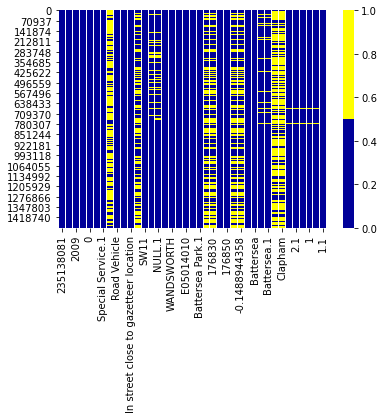

In [5]:
# Lets see if the data has missing values.
cols = LFB_data.columns[:]
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(LFB_data[cols].isnull(), cmap=sns.color_palette(colours))
print("Yellow - Missing Values\nBlue - Non Missing")

In [6]:
# Dividing the data into numerical and categorical for easier cleaning
# select numeric columns
df_numeric = LFB_data.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)


['2009' '0' 'NULL' 'NULL.1' '528652' '176830' '528650' '176850'
 '51.4758117319' '-0.1488944358' '319' '342' '2' '2.1' '2.2' '1' '255'
 '1.1']


In [7]:

# select non numeric columns
df_categorical = LFB_data.select_dtypes(exclude=[np.number])
non_numeric_cols = df_categorical.columns.values
print(non_numeric_cols)

['235138081' '01 Jan 2009' '00:00:37' 'Special Service'
 'Special Service.1' 'RTC' 'Road Vehicle' 'Car '
 'In street close to gazetteer location' 'SW11 4LB' 'SW11' 'E09000032'
 'WANDSWORTH' 'Wandsworth' 'E05014010' 'Battersea Park' 'Battersea Park.1'
 'London' 'Battersea' 'Battersea.1' 'Clapham']


In [8]:
df_categorical.isnull().sum()

235138081                                      0
01 Jan 2009                                    0
00:00:37                                       0
Special Service                                0
Special Service.1                              0
RTC                                      1021971
Road Vehicle                                   0
Car                                            0
In street close to gazetteer location          0
SW11 4LB                                  718476
SW11                                           0
E09000032                                      0
WANDSWORTH                                     0
Wandsworth                                     0
E05014010                                      3
Battersea Park                                 3
Battersea Park.1                               3
London                                         0
Battersea                                      1
Battersea.1                               121411
Clapham             

We can see that we have a couple of categorical columns with missing values

In [9]:
df_categorical.head()

,235138081,01 Jan 2009,00:00:37,Special Service,Special Service.1,RTC,Road Vehicle,Car,In street close to gazetteer location,SW11 4LB,...,E09000032,WANDSWORTH,Wandsworth,E05014010,Battersea Park,Battersea Park.1,London,Battersea,Battersea.1,Clapham
0,1091,01 Jan 2009,00:00:46,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest gazetteer location,SE1 7SG,...,E09000022,LAMBETH,Lambeth,E05014118,Waterloo & South Bank,Waterloo & South Bank,London,Lambeth,NaN,NaN
1,2091,01 Jan 2009,00:03:00,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside gazetteer location,N9 9EL,...,E09000010,ENFIELD,Enfield,E05013682,Haselbury,Haselbury,London,Edmonton,Edmonton,NaN
2,3091,01 Jan 2009,00:04:27,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10 0DG,...,E09000017,HILLINGDON,Hillingdon,E05013571,Hillingdon East,Hillingdon East,London,Hillingdon,Hillingdon,NaN
3,5091,01 Jan 2009,00:05:39,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside gazetteer location,N7 8HG,...,E09000019,ISLINGTON,Islington,E05013708,Laycock,Laycock,London,Holloway,Holloway,Holloway
4,6091,01 Jan 2009,00:06:03,False Alarm,AFA,NaN,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,NaN,...,E09000007,CAMDEN,Camden,E05013663,Kentish Town North,Kentish Town North,London,Kentish Town,Kentish Town,Kentish Town


In [10]:
df_categorical.value_counts()

235138081        01 Jan 2009  00:00:37  Special Service  Special Service.1  RTC                              Road Vehicle     Car                 In street close to gazetteer location         SW11 4LB  SW11  E09000032  WANDSWORTH            Wandsworth            E05014010  Battersea Park           Battersea Park.1         London  Battersea     Battersea.1   Clapham     
1151             01 Jan 2015  00:02:15  Special Service  Special Service    RTC                              Road Vehicle     Car                 In street outside gazetteer location          CR0 5RE   CR0   E09000008  CROYDON               Croydon               E05011484  South Croydon            South Croydon            London  Addington     Addington     Addington       1
055660-04052017  04 May 2017  10:28:42  Special Service  Special Service    Making Safe (not RTC)            Non Residential  Single shop         Correct incident location                     E17 4PG   E17   E09000031  WALTHAM FOREST        Waltham 